# 6-layer CNN on Caltech101 with data augmentation

### Data processing with keras.
 Documentaiton for *ImageDataGenerator* and *flow_from_directory*: https://keras.io/api/preprocessing/image/
 

In [5]:
# Image processing from local files

from keras.preprocessing.image import ImageDataGenerator
image_size = 150


# Define directory roots
train_root = './101_ObjectCategories_test/101_ObjectCategories/train'
val_root = './101_ObjectCategories_test/101_ObjectCategories/val'
test_root = './101_ObjectCategories_test/101_ObjectCategories/test'

# Generate training set with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  )

train_dataset = train_datagen.flow_from_directory(
    train_root,
    target_size=(image_size, image_size),
    batch_size=32
)


# Generate validation set   
val_datagen = ImageDataGenerator(rescale=1./255.)

val_dataset = val_datagen.flow_from_directory(
    val_root,
    target_size=(image_size, image_size),
    batch_size=32
)

# Generate test set
test_datagen = ImageDataGenerator(rescale=1./255.)

test_dataset = test_datagen.flow_from_directory(
    test_root,
    target_size=(image_size, image_size),
    batch_size=32,
    shuffle=False
)

total_length = len(train_dataset.filenames) + len(val_dataset.filenames) + len(test_dataset.filenames)
print("Train, in percentage (%) : ", len(train_dataset.filenames)/total_length * 100)
print("Val, in percentage (%) : ", len(val_dataset.filenames)/total_length * 100)
print("Test, in percentage (%) : ", len(test_dataset.filenames)/total_length * 100)

Found 6782 images belonging to 102 classes.
Found 1464 images belonging to 102 classes.
Found 898 images belonging to 102 classes.
Train, in percentage (%) :  74.16885389326335
Val, in percentage (%) :  16.010498687664043
Test, in percentage (%) :  9.820647419072616


## Next, we need to define the CNN

Documentation for sequential model: https://keras.io/guides/sequential_model/

Documentation for Conv2C layer: https://keras.io/api/layers/convolution_layers/convolution2d/

Documentation for MaxPooling2D layer: https://keras.io/api/layers/pooling_layers/max_pooling2d/

Documentation for Flatten layer: https://keras.io/api/layers/reshaping_layers/flatten/

Documentation for Dense layer: https://keras.io/api/layers/core_layers/dense/

In [6]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(102, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

## Now, we need to compile and fit the model

For compile we define the loss function, the optimizer and the performance metrics. 

Fit is the training of the model. It uses the training data to train the model and the validation data to verify the performance of the model based on the performance metrics defined in compile. 

Documentation for compile and fit: https://keras.io/api/models/model_training_apis/

In [7]:
# Compile and fit model
import keras

from tensorflow.keras.metrics import Precision, Recall

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy', 
                       'top_k_categorical_accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    )

Epoch 1/100
212/212 [==============================] - 125s 592ms/step - loss: 4.2318 - acc: 0.1184 - top_k_categorical_accuracy: 0.3039 - val_loss: 4.0382 - val_acc: 0.1783 - val_top_k_categorical_accuracy: 0.3572
Epoch 2/100
212/212 [==============================] - 124s 585ms/step - loss: 3.9711 - acc: 0.1976 - top_k_categorical_accuracy: 0.3719 - val_loss: 3.8867 - val_acc: 0.1878 - val_top_k_categorical_accuracy: 0.3996
Epoch 3/100
212/212 [==============================] - 121s 570ms/step - loss: 3.7841 - acc: 0.2358 - top_k_categorical_accuracy: 0.3984 - val_loss: 3.6185 - val_acc: 0.2842 - val_top_k_categorical_accuracy: 0.4276
Epoch 4/100
212/212 [==============================] - 120s 568ms/step - loss: 3.6103 - acc: 0.2560 - top_k_categorical_accuracy: 0.4280 - val_loss: 3.5039 - val_acc: 0.2903 - val_top_k_categorical_accuracy: 0.4645
Epoch 5/100
212/212 [==============================] - 122s 575ms/step - loss: 3.4568 - acc: 0.2768 - top_k_categorical_accuracy: 0.4540 - v

## After the model is finished training we store the weights and the history of the model

This info is stored such that we can evaluate to model without having to repeatedly train it. 

The weights are saved through model.save. Documentation for the save function: https://www.tensorflow.org/guide/keras/save_and_serialize

The history is stored with numpy as this is convenient given the dictionary structure. Documentaion on numpy.save: https://numpy.org/devdocs/reference/generated/numpy.save.html

In [8]:
# Store model

model.save("./model_weights/6layer_data_augmentation.h5")

In [9]:
# Save history of model

import numpy as np
data_history_training = history.history

np.save('./model_histories/6layer_data_augmentation.npy', data_history_training)
    

## Now that the model is saved, we can retrieve the model and history to test the model and plot results

The model is loaded with the in-built keras function. Documentation: https://www.tensorflow.org/guide/keras/save_and_serialize

We evaluate the model with the evaluate function. This gives loss and the performance metrics specified in compile. Documentation: https://keras.io/api/models/model_training_apis/

The history for training is retrieved with numpy.load. Documentation: https://numpy.org/doc/stable/reference/generated/numpy.load.html

Finally, the history is visualized with matplotlib. Documentation: https://matplotlib.org/



In [10]:
# Evaluate model

from tensorflow import keras

reconstructed_model = keras.models.load_model("./model_weights/6layer_data_augmentation.h5")
reconstructed_model.evaluate(test_dataset)

29/29 [==============================] - 7s 227ms/step - loss: 1.9008 - acc: 0.5668 - top_k_categorical_accuracy: 0.7606


[1.9007657591638893, 0.56681514, 0.76057905]

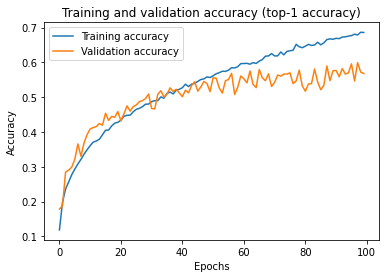

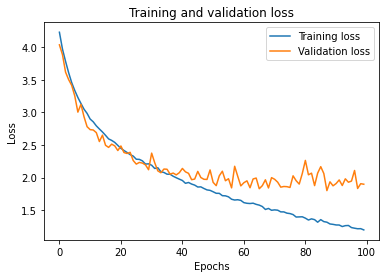

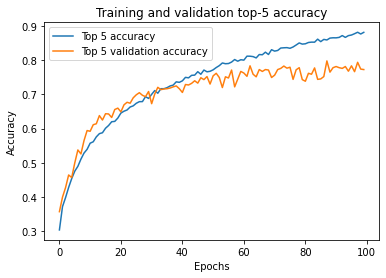

In [11]:
# Plot from stored history

import numpy as np
reconstructed_history = np.load('./model_histories/6layer_data_augmentation.npy',allow_pickle='TRUE').item()

import matplotlib.pyplot as plt

acc = reconstructed_history['acc']
val_acc = reconstructed_history['val_acc']

loss = reconstructed_history['loss']
val_loss = reconstructed_history['val_loss']

top_5_acc = reconstructed_history['top_k_categorical_accuracy']
top_5_val_acc = reconstructed_history['val_top_k_categorical_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy (top-1 accuracy)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()

plt.plot(epochs, top_5_acc, label='Top 5 accuracy')
plt.plot(epochs, top_5_val_acc, label='Top 5 validation accuracy')
plt.title('Training and validation top-5 accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()



## Lastly, we use the model to predict the output on the test data

The predict function returns the softmax output defined in the model. Hence, the output from every image is a array of shape (102,). Using the numpy.argmax function gives the most probable class. Documentation on predict: https://keras.io/api/models/model_training_apis/

Finally, we use the sklearn library to generate the classification report. Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [15]:
from tensorflow import keras

reconstructed_model = keras.models.load_model("./model_weights/6layer_data_augmentation.h5")
predicted = reconstructed_model.predict(test_dataset)

In [16]:
import sklearn

true = test_dataset.classes
predicted = [np.argmax(x) for x in predicted]
predicted = np.array(predicted)
labels = test_dataset.class_indices

print('\n', sklearn.metrics.classification_report(true, predicted, target_names=labels), sep='') 


                   precision    recall  f1-score   support

BACKGROUND_Google       0.31      0.36      0.33        42
            Faces       1.00      0.98      0.99        45
       Faces_easy       1.00      1.00      1.00        35
         Leopards       1.00      0.48      0.65        25
       Motorbikes       0.95      0.90      0.92        80
        accordion       0.56      0.83      0.67         6
        airplanes       0.98      0.92      0.95        87
           anchor       0.00      0.00      0.00         5
              ant       0.00      0.00      0.00         2
           barrel       0.00      0.00      0.00         4
             bass       1.00      0.12      0.22         8
           beaver       1.00      0.20      0.33         5
        binocular       0.20      0.33      0.25         3
           bonsai       0.79      0.69      0.73        16
            brain       0.60      0.67      0.63         9
     brontosaurus       1.00      0.33      0.50      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
